In [ ]:
# Import packages
import os
import cv2
import numpy as np
import glob
import random
from tensorflow.lite.python.interpreter import Interpreter
import matplotlib.pyplot as plt

%matplotlib inline

# Define function for inferencing with TFLite model and displaying results
def tflite_detect_images(modelpath, imgpath, lblpath, min_conf=0.5, num_test_images=10, savepath='/content/results', txt_only=False):

    # Grab filenames of all images in test folder
    images = glob.glob(os.path.join(imgpath, '*.jpg')) + glob.glob(os.path.join(imgpath, '*.jpeg')) + glob.glob(os.path.join(imgpath, '*.png')) + glob.glob(os.path.join(imgpath, '*.bmp'))

    # Adjust the number of test images if it exceeds the available images
    num_test_images = min(num_test_images, len(images))

    # Load the label map into memory
    with open(lblpath, 'r') as f:
        labels = [line.strip() for line in f.readlines()]

    # Load the Tensorflow Lite model into memory
    interpreter = Interpreter(model_path=modelpath)
    interpreter.allocate_tensors()

    # Get model details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    height = input_details[0]['shape'][1]
    width = input_details[0]['shape'][2]

    float_input = (input_details[0]['dtype'] == np.float32)

    input_mean = 127.5
    input_std = 127.5

    # Randomly select test images
    images_to_test = random.sample(images, num_test_images)

    # Loop over every image and perform detection
    for image_path in images_to_test:

        # Load image and resize to expected shape [1xHxWx3]
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        imH, imW, _ = image.shape
        image_resized = cv2.resize(image_rgb, (width, height))
        input_data = np.expand_dims(image_resized, axis=0)

        # Normalize pixel values if using a floating model (i.e. if model is non-quantized)
        if float_input:
            input_data = (np.float32(input_data) - input_mean) / input_std

        # Perform the actual detection by running the model with the image as input
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()

        # Retrieve detection results
        boxes = interpreter.get_tensor(output_details[1]['index'])[0]  # Bounding box coordinates of detected objects
        classes = interpreter.get_tensor(output_details[3]['index'])[0]  # Class index of detected objects
        scores = interpreter.get_tensor(output_details[0]['index'])[0]  # Confidence of detected objects

        detections = []

        # Loop over all detections and draw detection box if confidence is above minimum threshold
        for i in range(len(scores)):
            if ((scores[i] > min_conf) and (scores[i] <= 1.0)):

                # Get bounding box coordinates and draw box
                # Interpreter can return coordinates that are outside of image dimensions, need to force them to be within image using max() and min()
                ymin = int(max(1, (boxes[i][0] * imH)))
                xmin = int(max(1, (boxes[i][1] * imW)))
                ymax = int(min(imH, (boxes[i][2] * imH)))
                xmax = int(min(imW, (boxes[i][3] * imW)))

                cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (10, 255, 0), 2)

                # Draw label
                object_name = labels[int(classes[i])]  # Look up object name from "labels" array using class index
                label = '%s: %d%%' % (object_name, int(scores[i] * 100))  # Example: 'person: 72%'
                labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)  # Get font size
                label_ymin = max(ymin, labelSize[1] + 10)  # Make sure not to draw label too close to top of window
                cv2.rectangle(image, (xmin, label_ymin - labelSize[1] - 10), (xmin + labelSize[0], label_ymin + baseLine - 10), (255, 255, 255), cv2.FILLED)  # Draw white box to put label text in
                cv2.putText(image, label, (xmin, label_ymin - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)  # Draw label text

                # Print detection results
                print(f'Detected object: {object_name}, Confidence: {int(scores[i] * 100)}%')

                detections.append([object_name, scores[i], xmin, ymin, xmax, ymax])

        # All the results have been drawn on the image, now display the image
        if txt_only == False:  # "text_only" controls whether we want to display the image results or just save them in .txt files
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(12, 16))
            plt.imshow(image)
            plt.show()

        # Save detection results in .txt files (for calculating mAP)
        elif txt_only == True:

            # Get filenames and paths
            image_fn = os.path.basename(image_path)
            base_fn, ext = os.path.splitext(image_fn)
            txt_result_fn = base_fn + '.txt'
            txt_savepath = os.path.join(savepath, txt_result_fn)

            # Write results to text file
            # (Using format defined by https://github.com/Cartucho/mAP, which will make it easy to calculate mAP)
            with open(txt_savepath, 'w') as f:
                for detection in detections:
                    f.write('%s %.4f %d %d %d %d\n' % (detection[0], detection[1], detection[2], detection[3], detection[4], detection[5]))

    return

# Set up variables for running user's model
PATH_TO_IMAGES = '/content/gambar'  # Path to test images folder
PATH_TO_MODEL = '/content/detect.tflite'  # Path to .tflite model file
PATH_TO_LABELS = '/content/labelmap.txt'  # Path to labelmap.txt file
min_conf_threshold = 0.5  # Confidence threshold (try changing this to 0.01 if you don't see any detection results)

# Count the number of images in the directory
images_to_test = len(glob.glob(os.path.join(PATH_TO_IMAGES, '*.jpg')) +
                     glob.glob(os.path.join(PATH_TO_IMAGES, '*.jpeg')) +
                     glob.glob(os.path.join(PATH_TO_IMAGES, '*.png')) +
                     glob.glob(os.path.join(PATH_TO_IMAGES, '*.bmp')))  # Number of images to run detection on

# Run function
tflite_detect_images(PATH_TO_MODEL, PATH_TO_IMAGES, PATH_TO_LABELS, min_conf_threshold, images_to_test)


Found 2 images to test
Grabbing filenames of all images in test folder...
Found 2 images in the folder
Testing on 2 images
Loaded 8 labels
Selected images: ['/content/Testing/1.jpg', '/content/Testing/2.jpeg']
Processing image: /content/Testing/1.jpg
Detected object with confidence 0.9863553643226624
Detected object: Nasi, Confidence: 98%
Detected object with confidence 0.9810755848884583
Detected object: Sayur, Confidence: 98%
Detected object with confidence 0.9408778548240662
Detected object: Tahu, Confidence: 94%
Detected object with confidence 0.9265481233596802
Detected object: Tempe, Confidence: 92%
Detected object with confidence 0.9245909452438354
Detected object: Tempe, Confidence: 92%


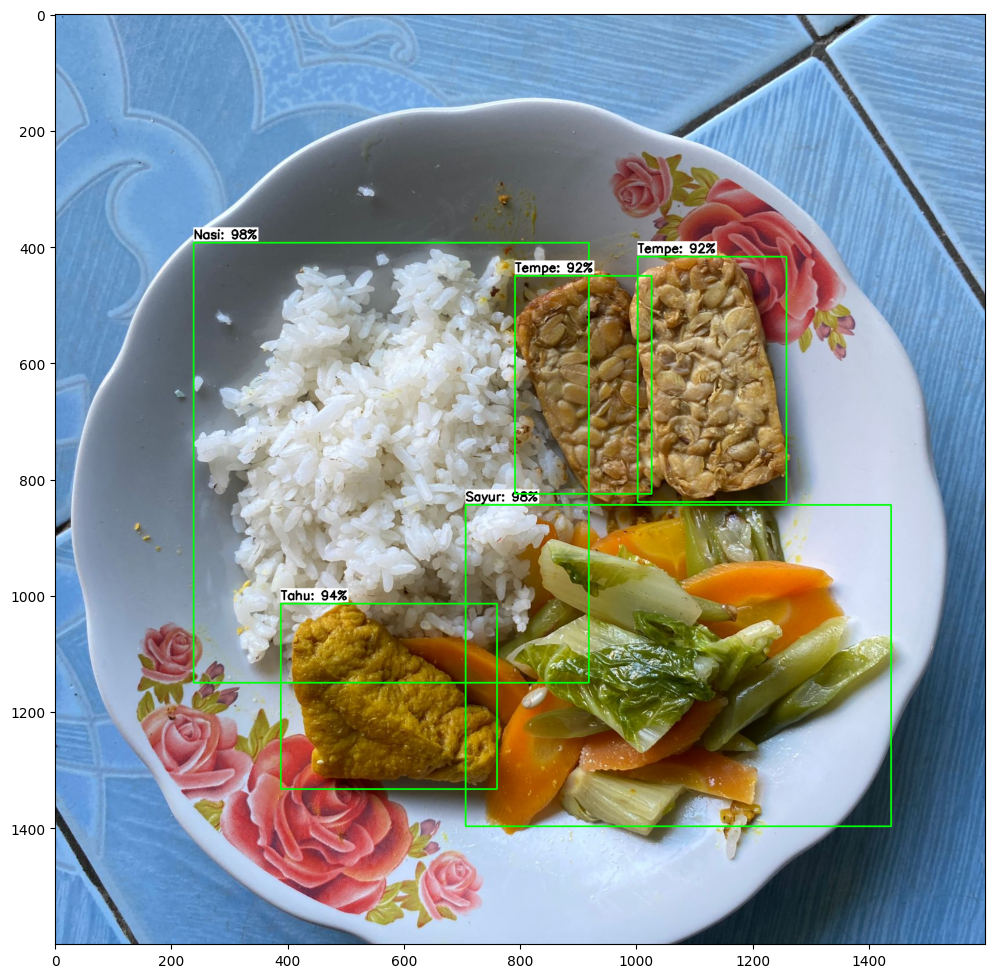

Processing image: /content/Testing/2.jpeg
Detected object with confidence 0.5995081663131714
Detected object: Sayur, Confidence: 59%
Detected object with confidence 0.5603777170181274
Detected object: Telur, Confidence: 56%


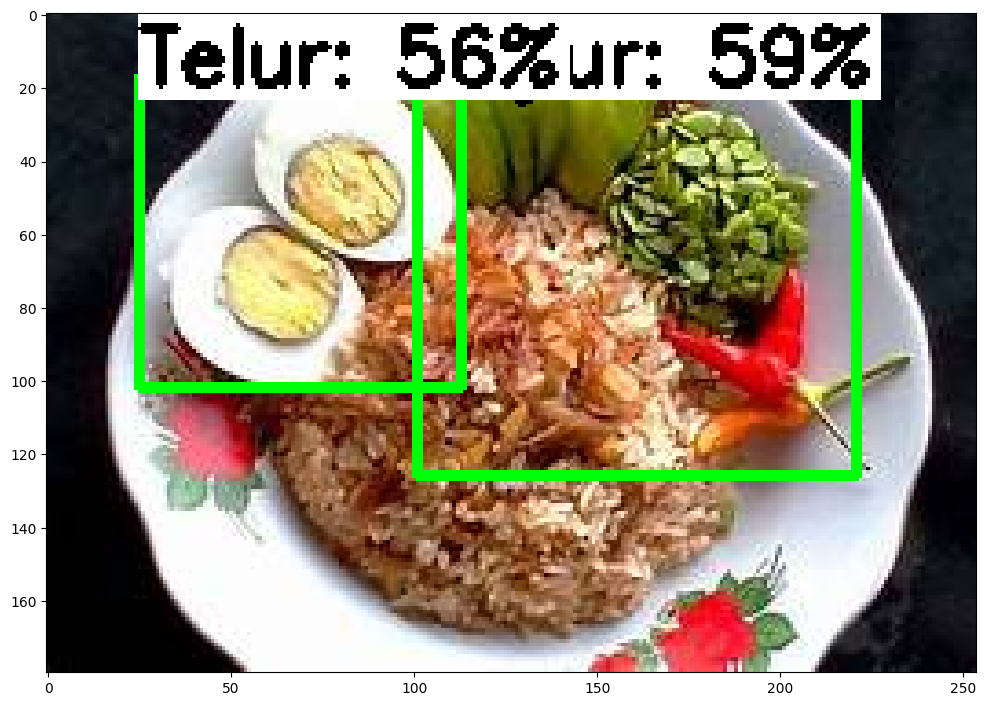

In [ ]:
# Import packages
import os
import cv2
import numpy as np
import glob
import random
from tensorflow.lite.python.interpreter import Interpreter
import matplotlib.pyplot as plt

%matplotlib inline

# Define function for inferencing with TFLite model and displaying results
def tflite_detect_images(modelpath, imgpath, lblpath, min_conf=0.5, num_test_images=10, savepath='/content/results', txt_only=False):
    print("Grabbing filenames of all images in test folder...")
    # Grab filenames of all images in test folder
    images = glob.glob(os.path.join(imgpath, '*.jpg')) + glob.glob(os.path.join(imgpath, '*.jpeg')) + glob.glob(os.path.join(imgpath, '*.png')) + glob.glob(os.path.join(imgpath, '*.bmp'))

    print(f"Found {len(images)} images in the folder")
    # Adjust the number of test images if it exceeds the available images
    num_test_images = min(num_test_images, len(images))
    print(f"Testing on {num_test_images} images")

    # Load the label map into memory
    with open(lblpath, 'r') as f:
        labels = [line.strip() for line in f.readlines()]

    print(f"Loaded {len(labels)} labels")

    # Load the Tensorflow Lite model into memory
    interpreter = Interpreter(model_path=modelpath)
    interpreter.allocate_tensors()

    # Get model details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    height = input_details[0]['shape'][1]
    width = input_details[0]['shape'][2]

    float_input = (input_details[0]['dtype'] == np.float32)

    input_mean = 127.5
    input_std = 127.5

    # Randomly select test images
    images_to_test = random.sample(images, num_test_images)
    print(f"Selected images: {images_to_test}")

    # Loop over every image and perform detection
    for image_path in images_to_test:
        print(f"Processing image: {image_path}")

        # Load image and resize to expected shape [1xHxWx3]
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        imH, imW, _ = image.shape
        image_resized = cv2.resize(image_rgb, (width, height))
        input_data = np.expand_dims(image_resized, axis=0)

        # Normalize pixel values if using a floating model (i.e. if model is non-quantized)
        if float_input:
            input_data = (np.float32(input_data) - input_mean) / input_std

        # Perform the actual detection by running the model with the image as input
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()

        # Retrieve detection results
        boxes = interpreter.get_tensor(output_details[1]['index'])[0]  # Bounding box coordinates of detected objects
        classes = interpreter.get_tensor(output_details[3]['index'])[0]  # Class index of detected objects
        scores = interpreter.get_tensor(output_details[0]['index'])[0]  # Confidence of detected objects

        detections = []

        # Loop over all detections and draw detection box if confidence is above minimum threshold
        for i in range(len(scores)):
            if ((scores[i] > min_conf) and (scores[i] <= 1.0)):
                print(f"Detected object with confidence {scores[i]}")
                # Get bounding box coordinates and draw box
                ymin = int(max(1, (boxes[i][0] * imH)))
                xmin = int(max(1, (boxes[i][1] * imW)))
                ymax = int(min(imH, (boxes[i][2] * imH)))
                xmax = int(min(imW, (boxes[i][3] * imW)))

                cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (10, 255, 0), 2)

                # Draw label
                object_name = labels[int(classes[i])]  # Look up object name from "labels" array using class index
                label = '%s: %d%%' % (object_name, int(scores[i] * 100))  # Example: 'person: 72%'
                labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)  # Get font size
                label_ymin = max(ymin, labelSize[1] + 10)  # Make sure not to draw label too close to top of window
                cv2.rectangle(image, (xmin, label_ymin - labelSize[1] - 10), (xmin + labelSize[0], label_ymin + baseLine - 10), (255, 255, 255), cv2.FILLED)  # Draw white box to put label text in
                cv2.putText(image, label, (xmin, label_ymin - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)  # Draw label text

                # Print detection results
                print(f'Detected object: {object_name}, Confidence: {int(scores[i] * 100)}%')

                detections.append([object_name, scores[i], xmin, ymin, xmax, ymax])

        # All the results have been drawn on the image, now display the image
        if txt_only == False:  # "text_only" controls whether we want to display the image results or just save them in .txt files
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(12, 16))
            plt.imshow(image)
            plt.show()

        # Save detection results in .txt files (for calculating mAP)
        elif txt_only == True:
            # Get filenames and paths
            image_fn = os.path.basename(image_path)
            base_fn, ext = os.path.splitext(image_fn)
            txt_result_fn = base_fn + '.txt'
            txt_savepath = os.path.join(savepath, txt_result_fn)

            # Write results to text file
            # (Using format defined by https://github.com/Cartucho/mAP, which will make it easy to calculate mAP)
            with open(txt_savepath, 'w') as f:
                for detection in detections:
                    f.write('%s %.4f %d %d %d %d\n' % (detection[0], detection[1], detection[2], detection[3], detection[4], detection[5]))

    return

# Set up variables for running user's model
PATH_TO_IMAGES = '/content/Testing'  # Path to test images folder
PATH_TO_MODEL = '/content/detect.tflite'  # Path to .tflite model file
PATH_TO_LABELS = '/content/labelmap.txt'  # Path to labelmap.txt file
min_conf_threshold = 0.5  # Confidence threshold (try changing this to 0.01 if you don't see any detection results)

# Count the number of images in the directory
images_to_test = len(glob.glob(os.path.join(PATH_TO_IMAGES, '*.jpg')) +
                     glob.glob(os.path.join(PATH_TO_IMAGES, '*.jpeg')) +
                     glob.glob(os.path.join(PATH_TO_IMAGES, '*.png')) +
                     glob.glob(os.path.join(PATH_TO_IMAGES, '*.bmp')))  # Number of images to run detection on

print(f"Found {images_to_test} images to test")

# Run function
tflite_detect_images(PATH_TO_MODEL, PATH_TO_IMAGES, PATH_TO_LABELS, min_conf_threshold, images_to_test)
